# Alzheimer prediction using gray matter density from T1w MRI

### Le Guillouzic Maël

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018

In [187]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
%pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# try:
#   import google.colab
#   IN_COLAB = True
#   print('You are using Google Colab')
#   !pip install googledrivedownloader
#   from googledrivedownloader import download_file_from_google_drive
# except:
#   IN_COLAB = False
IN_COLAB = False

Note: you may need to restart the kernel to use updated packages.


In [188]:
# if IN_COLAB:
#     print("you are using google colab")
#     download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
#     dest_path='./dataTP.npz')
#     download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
#     dest_path='./AtlasAAL2.nii')
#     download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
#     dest_path='./AtlasAICHA.nii')
#     download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
#     dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas
    y = data['y'] # classes, 0 for controls and 1 for patients
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS

In [189]:
# Choose Atlas (here AAL2)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


Using the library nilearn we can also plot the atlas used to define the ROIs:

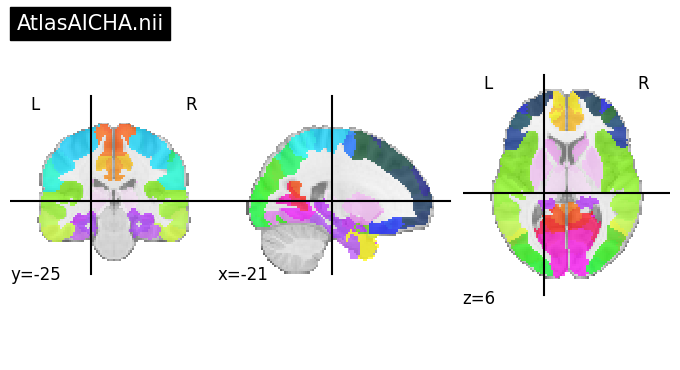

In [190]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [191]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(f'Nous avons {X_train.shape[0]} sujets dans l\'ensemble d\'entrainement et {X_test.shape[0]} sujets dans l\'ensemble de test')

Nous avons 601 sujets dans l'ensemble d'entrainement et 151 sujets dans l'ensemble de test


And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used.

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training.

**Reponse** En plottant les ROI, on observe une répartition entre 0 et 1. On va donc normaliser avec la fonction de base MinMaxScaler.

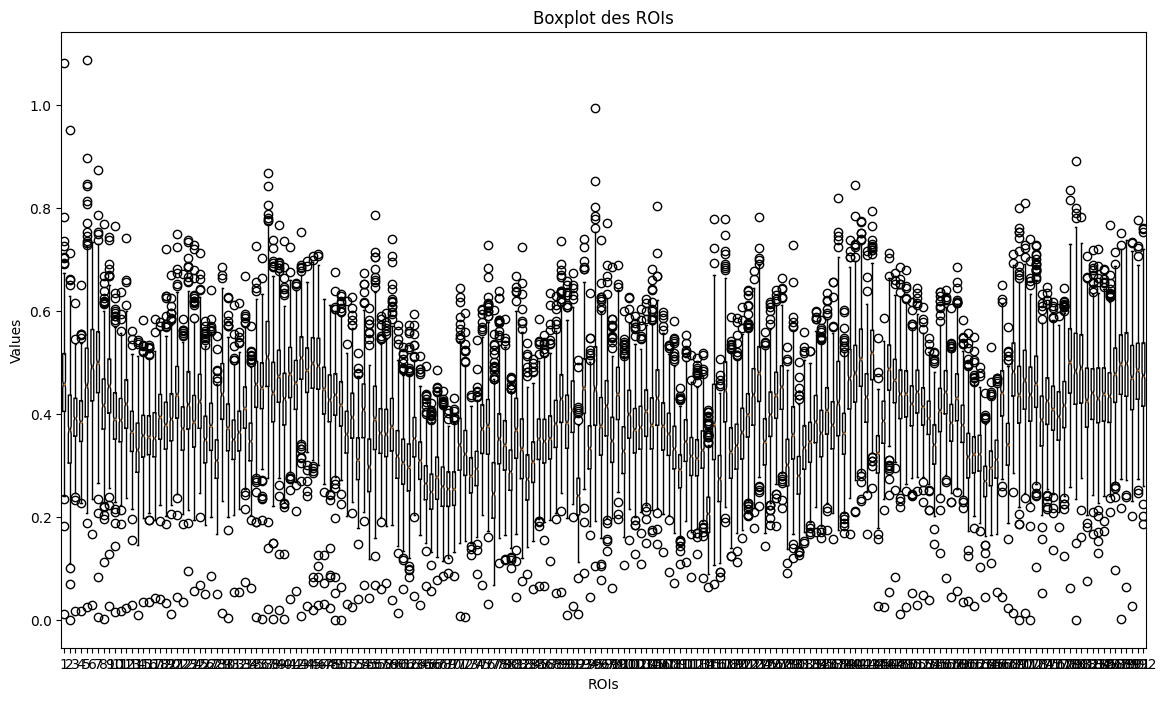

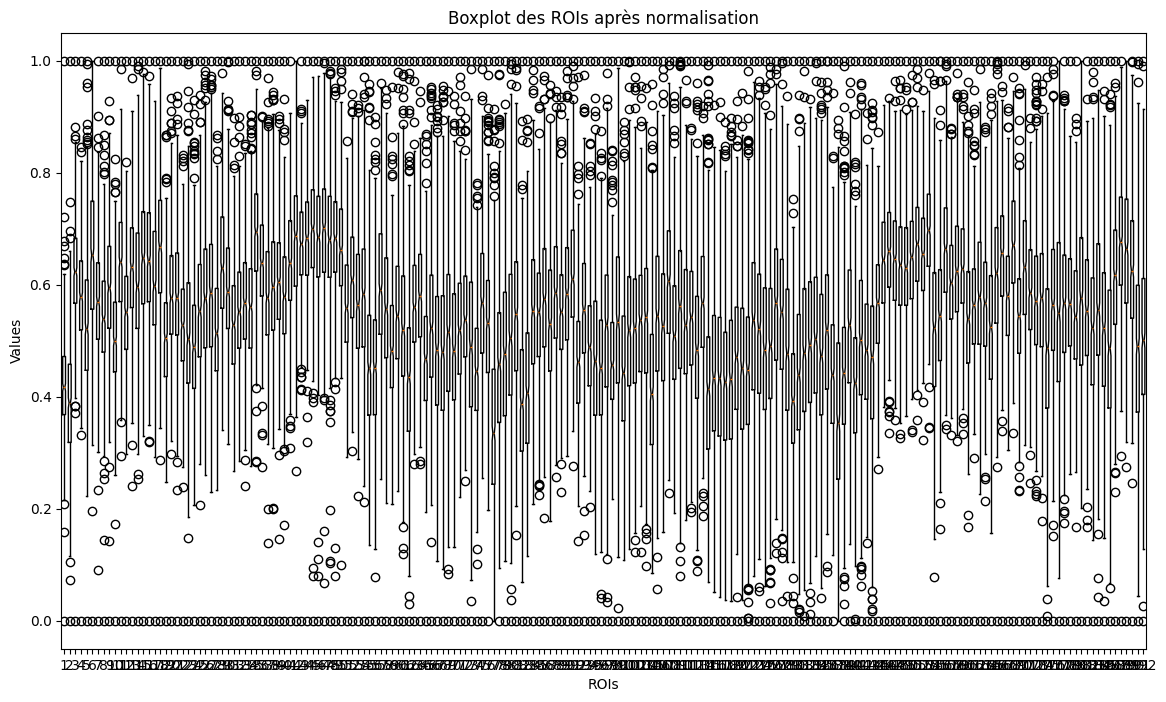

In [192]:
fig = plt.figure(figsize=(14,8))
plt.boxplot(X,notch=True)
plt.xlabel('ROIs')
plt.ylabel('Values')
plt.title('Boxplot des ROIs')
plt.show()

# Standardization/Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

fig = plt.figure(figsize=(14,8))
plt.boxplot(X_train,notch=True)
plt.xlabel('ROIs')
plt.ylabel('Values')
plt.title('Boxplot des ROIs après normalisation')
plt.show()


Then, we can fit a Decision tree, with the default setting, using the following code:

In [193]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7152317880794702


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ?

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  7


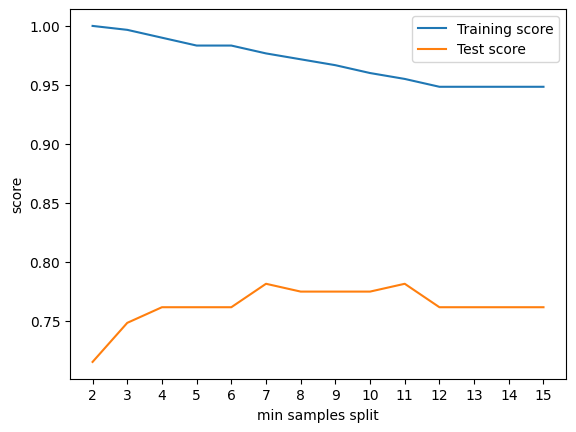

In [194]:
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score')
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score')
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend()

**Reponse** Ce qui pourrait etre sympa si on veut visualiser le meilleur min_samples_split et le meilleur min_samples_leaf, c'est de faire une sorte de heatmap, avec l'un en abscisse et l'autre en ordonnée. On sera alors obligé de visualiser séparement le train et le test. Ce qui nous motive à faire cela, c'est que si on fixe l'un puis l'autre on peut arriver dans une sorte de minimun local.

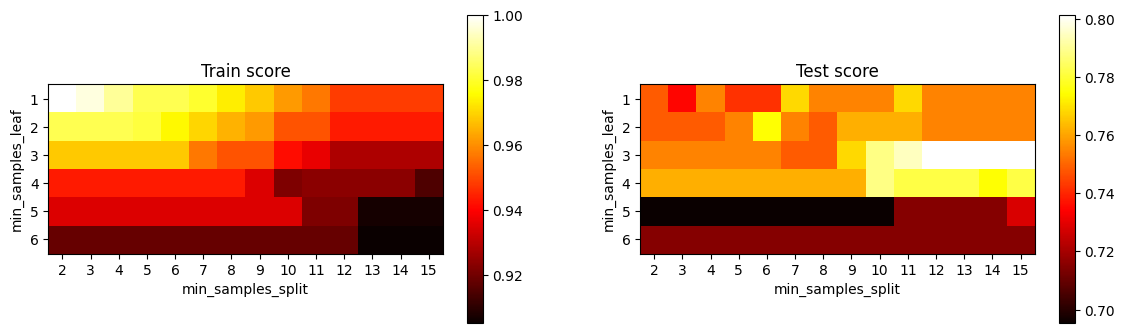

In [195]:
min_samples_split_range = range(2,16)
min_samples_leaf_range = range(1,7)

def recherche_param(X_train, y_train, X_test, y_test, random_state=10):
    train_score = np.zeros((len(min_samples_leaf_range),len(min_samples_split_range)))
    test_scores = np.zeros((len(min_samples_leaf_range),len(min_samples_split_range)))

    for i, min_samples_leaf in enumerate(min_samples_leaf_range):
        for j, min_samples_split in enumerate(min_samples_split_range):
            Tree = DecisionTreeClassifier(random_state=random_state, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            Tree.fit(X_train,y_train)
            train_score[i,j] = Tree.score(X_train,y_train)
            test_scores[i,j] = Tree.score(X_test,y_test)

    # Plot train et test
    fig = plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.imshow(train_score, interpolation='nearest', cmap=plt.cm.hot)
    plt.title('Train score')
    plt.xlabel('min_samples_split')
    plt.xticks(np.arange(len(min_samples_split_range)), min_samples_split_range)
    plt.yticks(np.arange(len(min_samples_leaf_range)), min_samples_leaf_range)
    plt.ylabel('min_samples_leaf')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(test_scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.title('Test score')
    plt.xlabel('min_samples_split')
    plt.xticks(np.arange(len(min_samples_split_range)), min_samples_split_range)
    plt.yticks(np.arange(len(min_samples_leaf_range)), min_samples_leaf_range)
    plt.ylabel('min_samples_leaf')
    plt.colorbar()
    plt.show()
    return train_score, test_scores

train_score, test_scores = recherche_param(X_train, y_train, X_test, y_test)

In [196]:
# On extrait les meilleurs paramètres
bestscore = np.max(test_scores)
bestparam = np.where(test_scores == bestscore)
print(bestscore)
print(bestparam)

# on remarque au'il y a en fait plusieurs endroit où le score est maximum
print(f"\n Les meilleurs paramètres sont donc min_samples_leaf = {min_samples_leaf_range[bestparam[0][0]]} et min_samples_split {min_samples_split_range[bestparam[1][0]]}")
print(f"Pour ces paramètres, le score de test est de {test_scores[bestparam][0]:.3f}")

0.8013245033112583
(array([2, 2, 2, 2]), array([10, 11, 12, 13]))

 Les meilleurs paramètres sont donc min_samples_leaf = 3 et min_samples_split 12
Pour ces paramètres, le score de test est de 0.801


Les meilleurs paramètres sont donc min_samples_leaf = 3 et min_samples_split varie entre 12 et 15.

Pour ces paramètres, le score de test est de 0.801

**Remarque** Ces résultats sont pour un random state de 10. Si on le change et on passe à 0, alors on a plus du tout les mêmes résultats : cf cellule ci dessous.

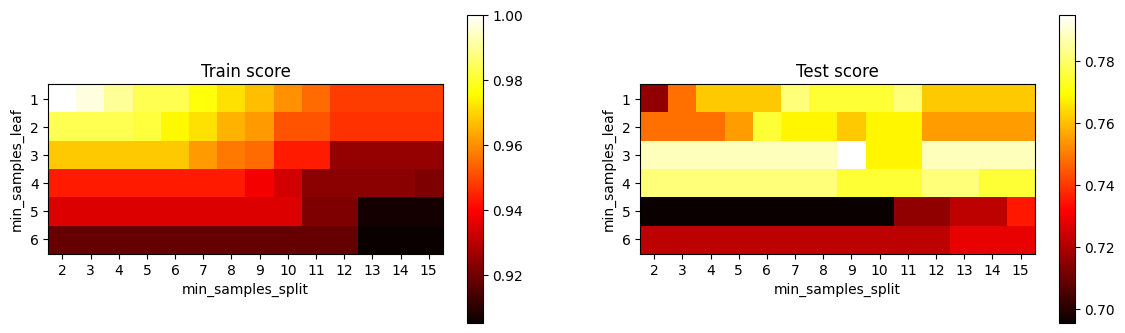


 Les meilleurs paramètres sont donc min_samples_leaf = 3 et min_samples_split 9
Pour ces paramètres, le score de test est de 0.795


In [197]:
train_score_12 , test_scores_12 = recherche_param(X_train, y_train, X_test, y_test, random_state=0)
bestscore_12 = np.max(test_scores_12)
bestparam_12 = np.where(test_scores_12 == bestscore_12)
print(f"\n Les meilleurs paramètres sont donc min_samples_leaf = {min_samples_leaf_range[bestparam_12[0][0]]} et min_samples_split {min_samples_split_range[bestparam_12[1][0]]}")
print(f"Pour ces paramètres, le score de test est de {test_scores_12[bestparam_12][0]:.3f}")

Try to add Gaussian noise to the data (using for instance zero mean and 0.02 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise.

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

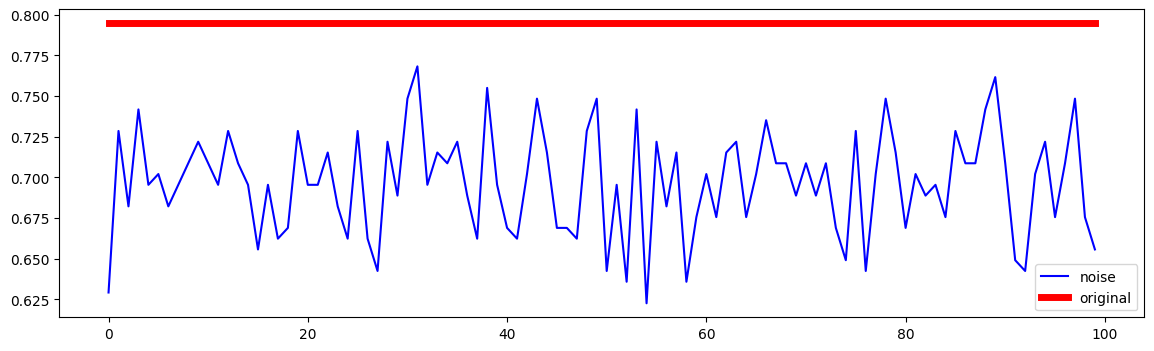

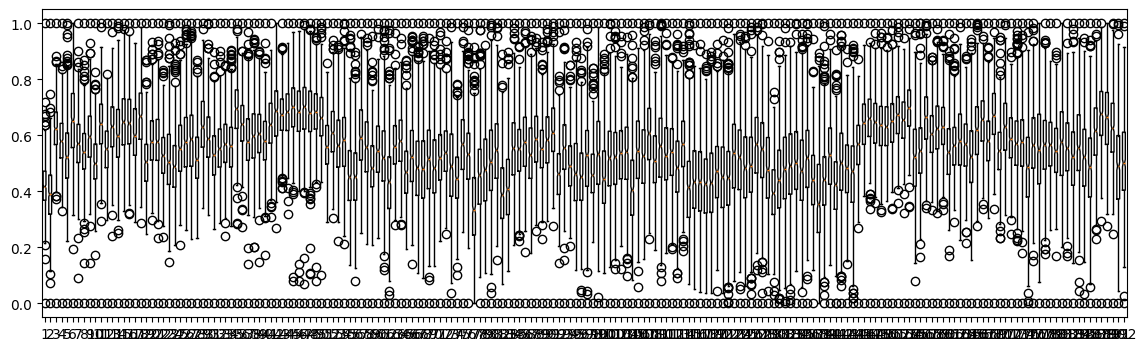

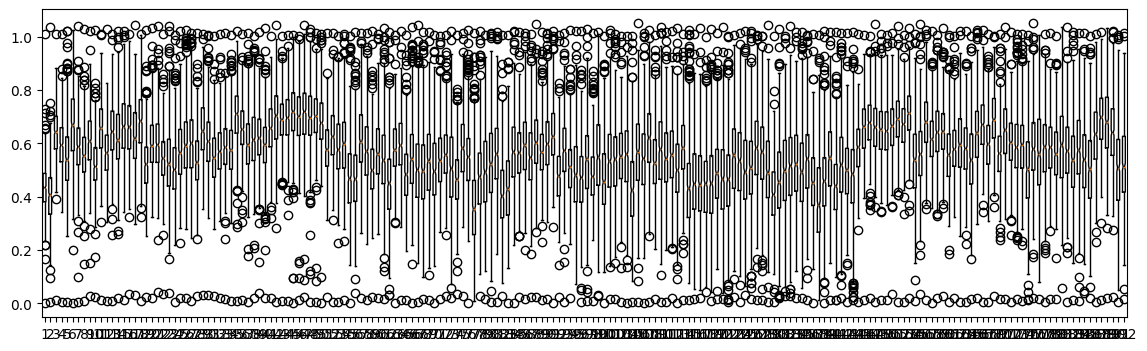

In [198]:
Tree = DecisionTreeClassifier(min_samples_split=9,min_samples_leaf=3,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):
    X_train_temp=np.copy(X_train)
    X_train_temp += np.abs(np.random.normal(0,0.02,X_train.shape))

    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)

fig = plt.figure(figsize=(14,4))
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,4))
plt.boxplot(X_train,notch=True)
plt.show()

fig = plt.figure(figsize=(14,4))
plt.boxplot(X_train_temp,notch=True)
plt.show()

**Réponse** Ajouter du bruit dégrade systématiquement les performances avec 10% de moins pour un bruit de $\sigma = 0.02$. 

On remarque que plus on en ajoute (avec par exemple $\sigma = 0.1$), plus les performances se dégradent.

**Inportant** Testons en standardisant plutot qu'en normalisant. On observe a priori la meme chose.

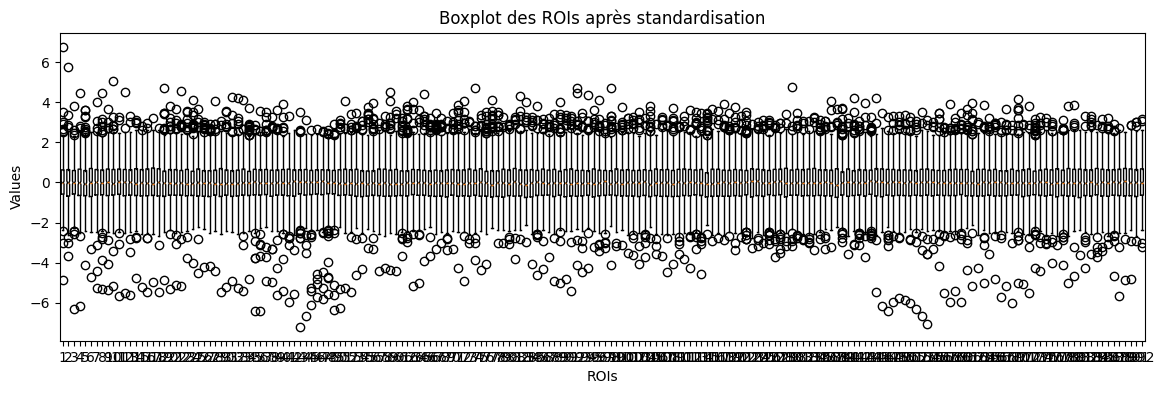

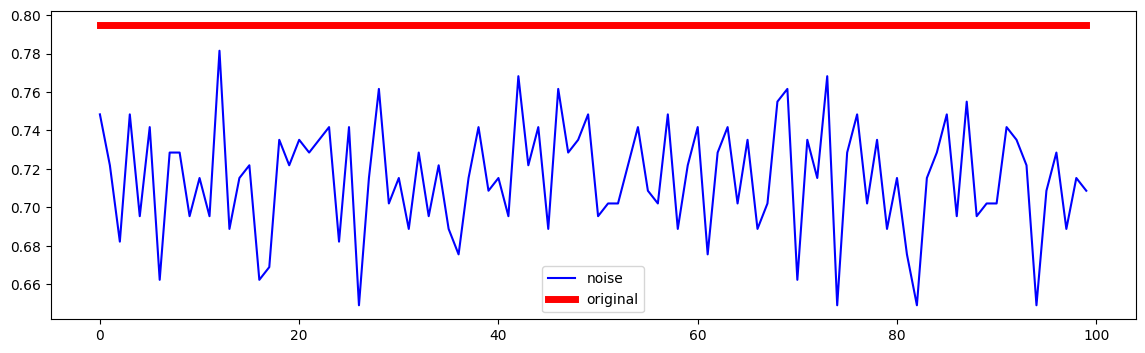

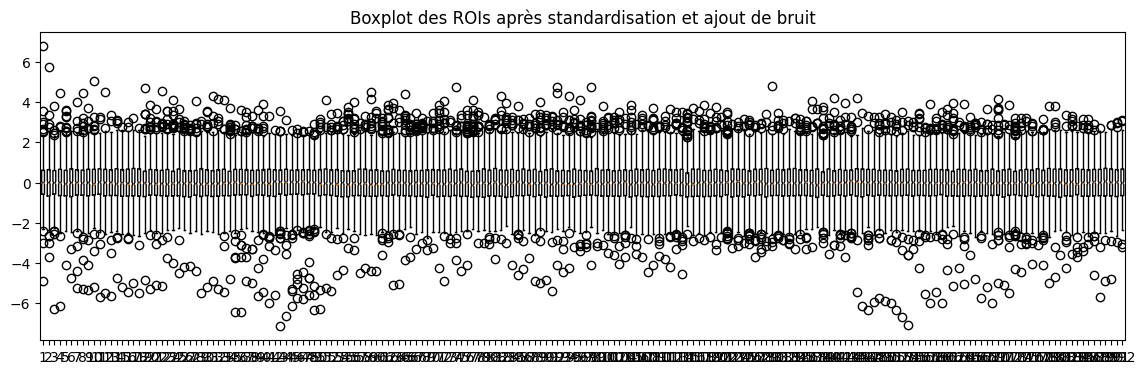

In [199]:
from sklearn.preprocessing import StandardScaler

X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X, y, test_size=0.2, random_state=10)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_scale)
X_test_scale = scaler.transform(X_test_scale)
fig = plt.figure(figsize=(14,4))
plt.boxplot(X_train_scale,notch=True)
plt.xlabel('ROIs')
plt.ylabel('Values')
plt.title('Boxplot des ROIs après standardisation')
plt.show()

Tree_scale = DecisionTreeClassifier(min_samples_split=9,min_samples_leaf=3,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree_scale.fit(X_train_scale,y_train_scale)
scoreTest[:] = Tree_scale.score(X_test_scale,y_test_scale)

for k in range(100):
    X_train_temp=np.copy(X_train_scale)
    X_train_temp += np.random.normal(0,0.02,X_train_scale.shape)

    Tree_scale.fit(X_train_temp,y_train_scale)
    scoreTestnoise[k] = Tree_scale.score(X_test_scale,y_test_scale)

fig = plt.figure(figsize=(14,4))
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend()
plt.show()

fig = plt.figure(figsize=(14,4))
plt.boxplot(X_train_temp,notch=True)
plt.title('Boxplot des ROIs après standardisation et ajout de bruit')
plt.show()

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*.

First plot the tree learnt on the original data, witout adding noise.

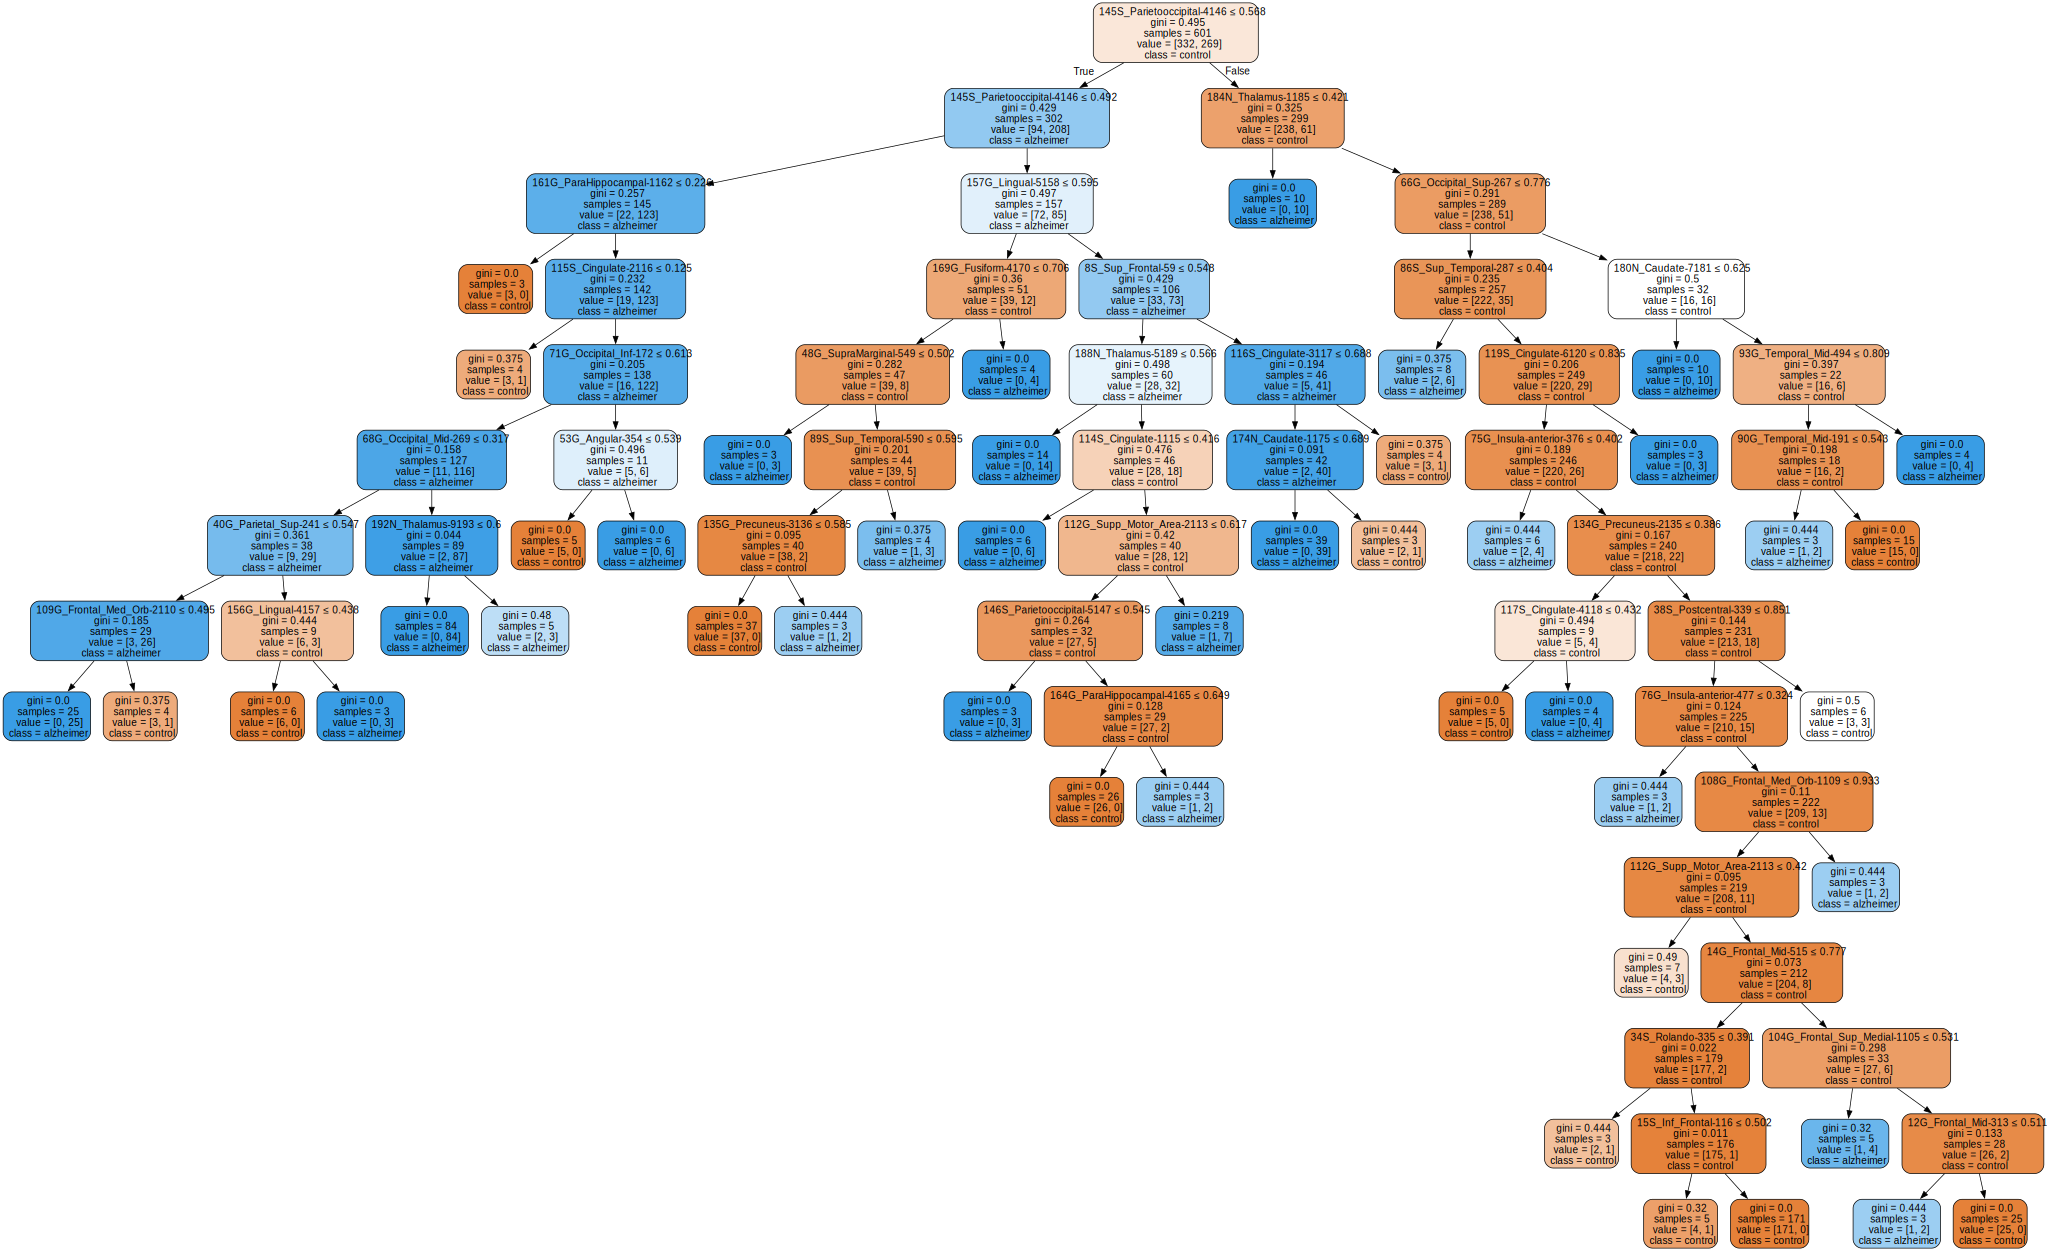

In [200]:
import graphviz

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Reponse** On remarque que les arbres sont a peu près similaires vers le haut avec des features identiques et des tresholds différents mais proches. Par contre vers le bas, on a des splits qui diffèrent.

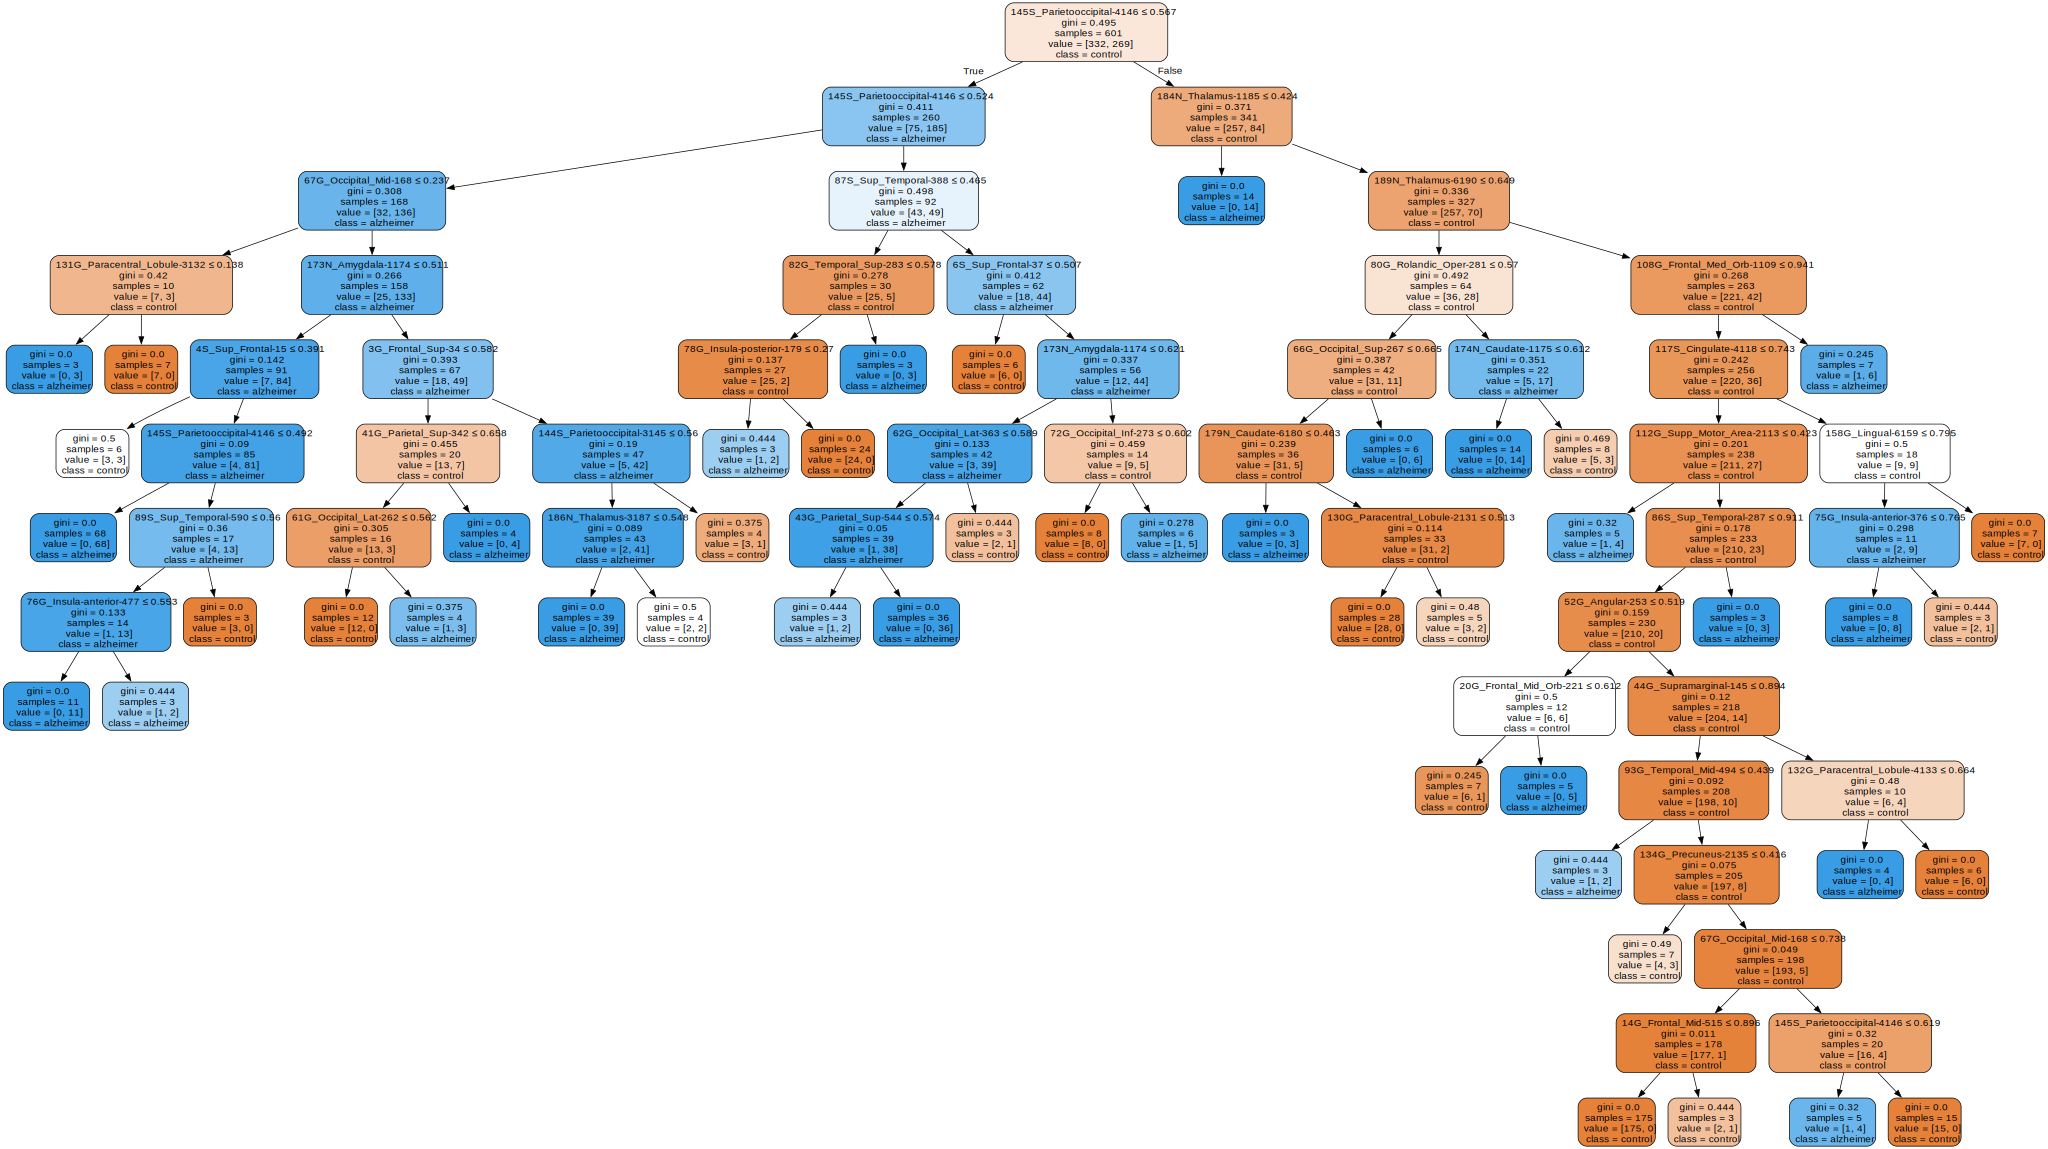

In [201]:
# plot the learnt tree on noisy data
X_train_temp = np.copy(X_train)
X_train_temp += np.abs(np.random.normal(0,0.02,X_train.shape))
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way.

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Réponse** On ne trouve pas les mêmes hyperparamètres qu'avec notre méthode précédente. Cette fois ci j'ai `Best params: {'min_samples_leaf': 6, 'min_samples_split': 14}`

In [202]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, n_jobs=-1, verbose=1)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params=grid_tree.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Validation Score: 0.7004820936639119
Best params: {'min_samples_leaf': 6, 'min_samples_split': 14}
Tree test score : 0.7284768211920529


**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Réponse** On refait un grid serach, cette fois ci avec de nouveau crierions pour voir si l'un d'eux est plus performant. On remarque qu'encore une fois, le paramètres trouvés changent ...

In [203]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5, n_jobs=-1, verbose=0, scoring='f1')
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params_f1=grid_tree.best_params_

Best Validation Score: 0.6579399591685064
Best params: {'min_samples_leaf': 2, 'min_samples_split': 5}
Tree test score : 0.704


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library.

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Réponse** On retrouve les mêmes features tout en haut de l'arbre : 145S et 184N. Cela semble logique car se sont les features qui permettent de split le plus efficacement les données.

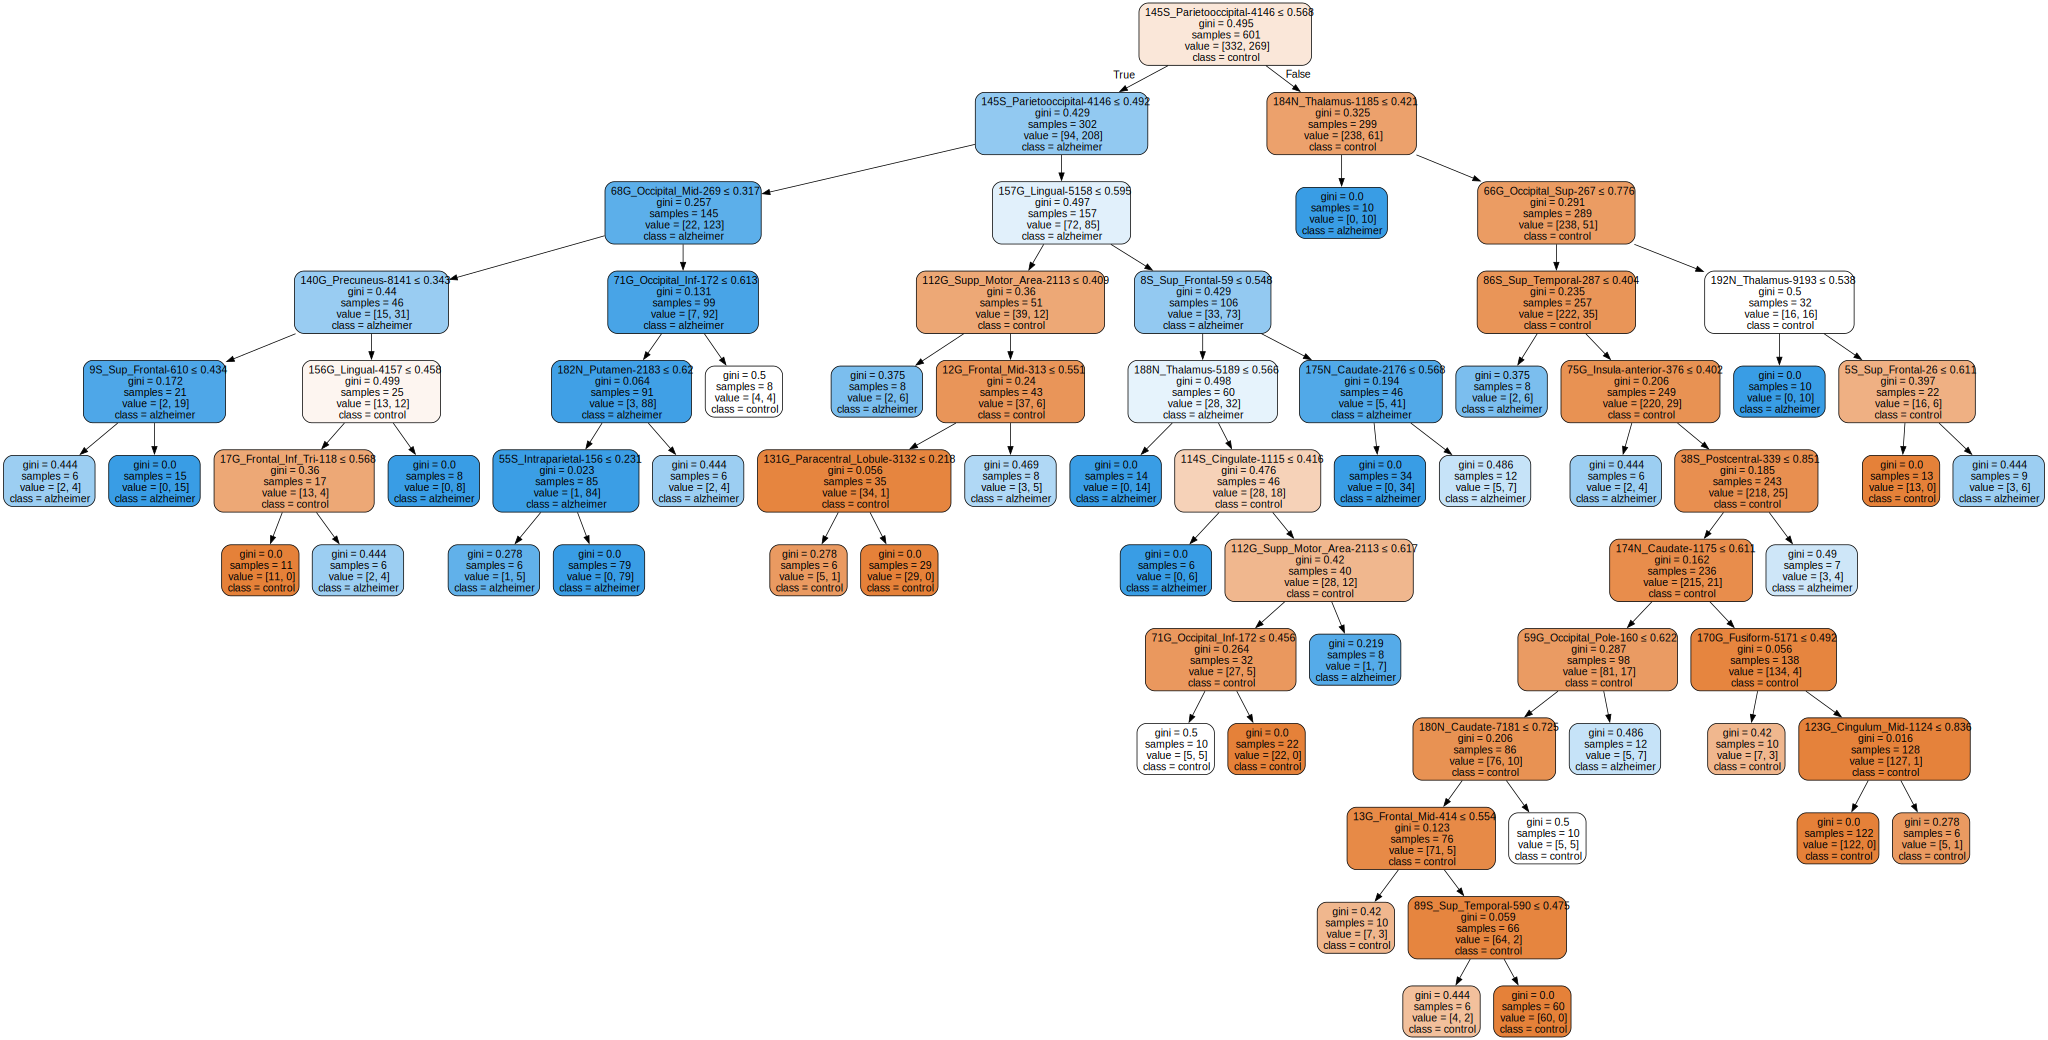

In [204]:
Tree = DecisionTreeClassifier(random_state=10, min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])
Tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'.

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ?

**Réponse** Avec bagging, les performances sont meilleures. Sur des data bruitées, on remarque le même phénomène qe tout à l'heure : le score baisse par rapport au même entrainement non bruité.

In [205]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5, n_jobs=-1, verbose=1)
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test, y_test))
best_params_bagging=grid_bagging.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Validation Score: 0.7736225895316805
Best params: {'n_estimators': 20}
Bagging test score : 0.8211920529801324


In [206]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5, n_jobs=-1, verbose=1)

X_train_temp = np.copy(X_train)
X_train_temp += np.abs(np.random.normal(0,0.02,X_train.shape))

grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test, y_test))
best_params=grid_bagging.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Validation Score: 0.7637327823691459
Best params: {'n_estimators': 20}
Bagging test score : 0.7880794701986755


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [207]:
RF=RandomForestClassifier(random_state=10)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2'], 'n_estimators': [10, 25,50,75,100, 200]}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test))

best_params_RF=grid_RF.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Validation Score: 0.7603030303030304
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}
Random Forest test score : 0.7350993377483444


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging.

In [208]:
# Random Forest on noisy data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2'],'n_estimators': [10, 25,50,75,100, 200]}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

X_train_temp = np.copy(X_train)
X_train_temp += np.abs(np.random.normal(0,0.02,X_train.shape))

grid_RF.fit(X_train_temp, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Validation Score: 0.7520247933884298
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 25}
Random Forest test score : 0.7350993377483444


**Reponse** Avec les randoms forest, j'ai les memes performances sur des données bruitées et non bruitées (`random_state=10`). Mais cela dépend encore une fois beaucoup de la seed de départ, si on met par exemple `random_state=0`, alors les performances sont même meilleures avec du bruit !

We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.077592)
2. feature 188 representing 189	N_Thalamus-6	190
 (0.060357)
3. feature 187 representing 188	N_Thalamus-5	189
 (0.038404)
4. feature 145 representing 146	S_Parietooccipital-5	147
 (0.033173)
5. feature 183 representing 184	N_Thalamus-1	185
 (0.022634)
6. feature 186 representing 187	N_Thalamus-4	188
 (0.022475)
7. feature 172 representing 173	N_Amygdala-1	174
 (0.021954)
8. feature 173 representing 174	N_Caudate-1	175
 (0.020880)
9. feature 189 representing 190	N_Thalamus-7	191
 (0.019122)
10. feature 171 representing 172	G_Fusiform-7	173
 (0.016720)


/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


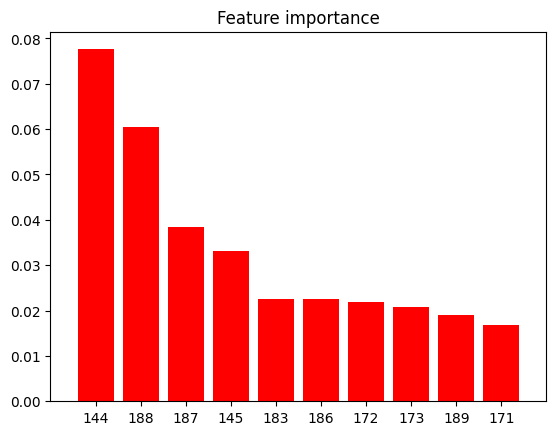

In [209]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense.

**Reponse** Les features les plus importantes sont pour nous 145-S_Parietooccipital-4, 188-N_Thalamus-5 et 173-N_Amygdala-1. Je suis allé voir dans les papiers de recherche, et je trouve les passages suivants :
- ""

We can also inspect the data using only pairs of the most important features

/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

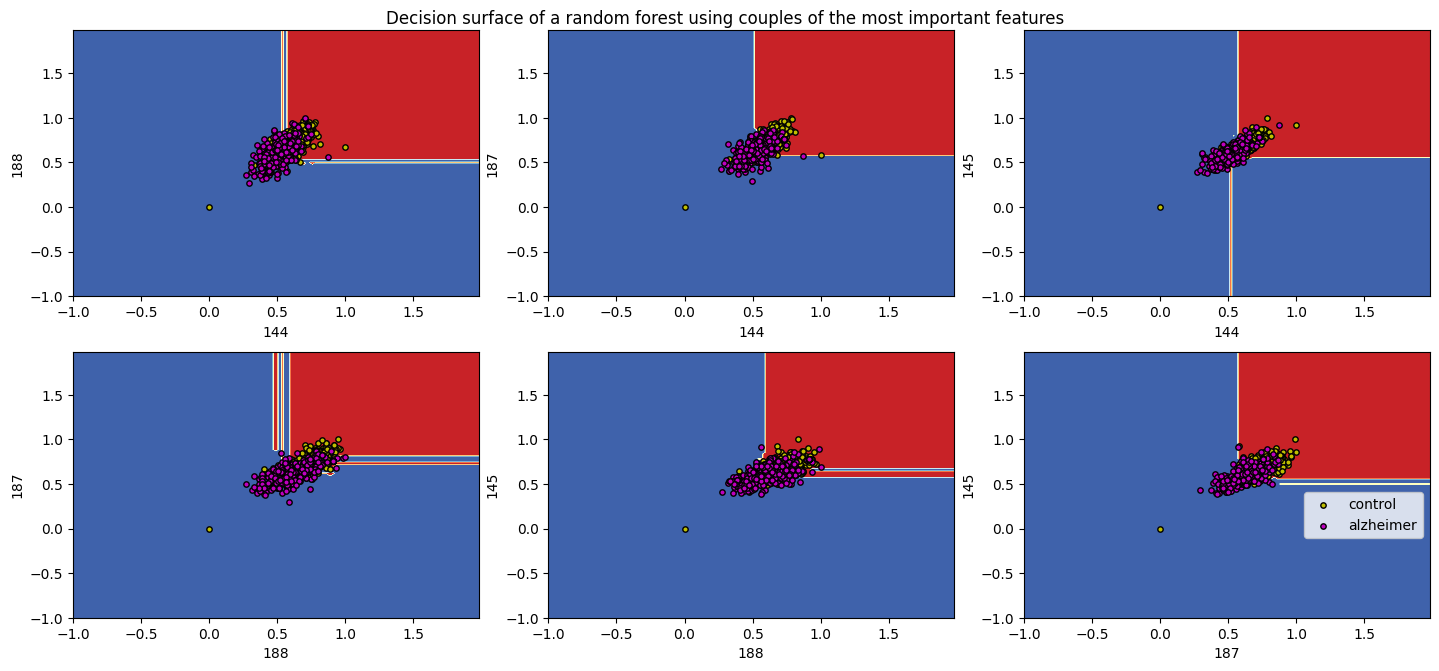

In [210]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i], edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Reponse** J'avoue ne pas trop savoir comment quantifier si un couple est mieux qu'un autre ?

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**INPORTANT** Je me suis trompé en début de TP, et puisqu'il disait que l'on pouvait tester sur différents Atlas j'ai tout de suite voulu tester sur AICHA et j'ai tout fait avec.

Je vais donc essayer de comparer les résultats principaux avec un autre Atlas ici : Hammer par exemple.

Dimensions des données HAMMERS: (752, 68)

--- Arbre de décision simple (HAMMERS) ---
Score train: 1.000
Score test: 0.728

--- Recherche de paramètres (GridSearchCV) ---
Meilleurs paramètres: {'min_samples_leaf': 5, 'min_samples_split': 11}
Score avec meilleurs paramètres: 0.735

--- Random Forest (HAMMERS) ---
Score train: 0.953
Score test: 0.815

--- Features les plus importantes (HAMMERS) ---
1. Right Amygdala                         (importance: 0.0970)
2. Left Amygdala                          (importance: 0.0814)
3. Left Hippocampus                       (importance: 0.0689)
4. Left Inferior Middle Temporal Gyri     (importance: 0.0450)
5. Left Lateral Temporal Ventricle        (importance: 0.0429)
6. Right Hippocampus                      (importance: 0.0402)
7. Left Ambient and Parahippocampus Gyri  (importance: 0.0379)
8. Right Lateral Temporal Ventricle       (importance: 0.0280)
9. Left Anterior Medial Temporal Lobe     (importance: 0.0268)
10. Right Inferior Middle Tempora

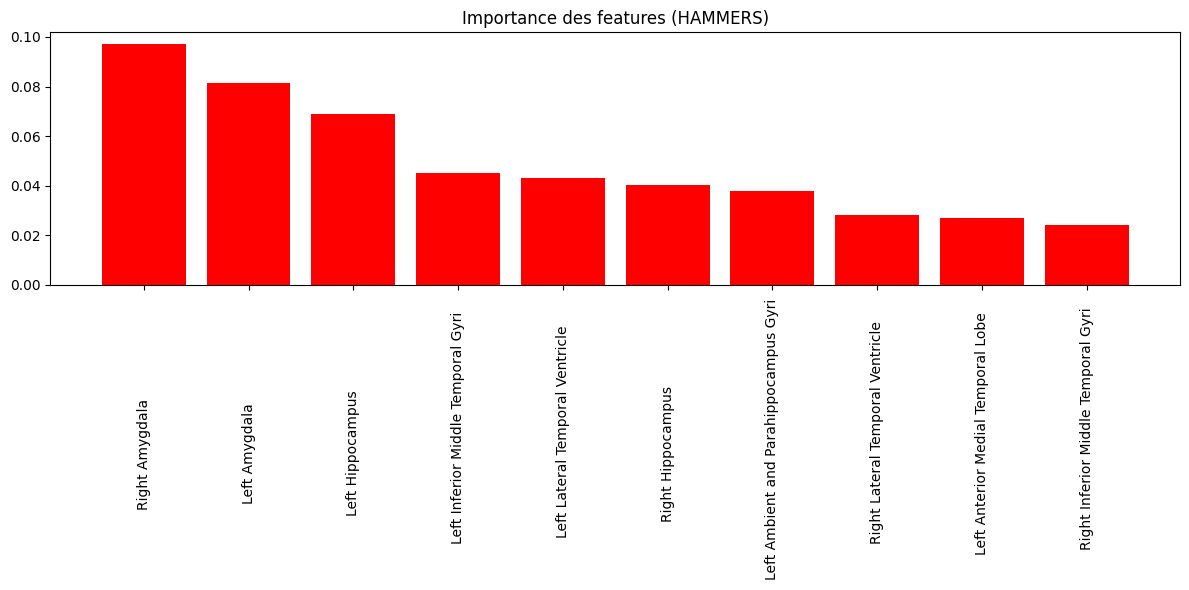


--- Comparaison HAMMERS vs AICHA ---
Score test HAMMERS: 0.815
Score test AICHA: 0.755

Top 5 features HAMMERS:
1. Right Amygdala                         (importance: 0.0970)
2. Left Amygdala                          (importance: 0.0814)
3. Left Hippocampus                       (importance: 0.0689)
4. Left Inferior Middle Temporal Gyri     (importance: 0.0450)
5. Left Lateral Temporal Ventricle        (importance: 0.0429)

Top 5 features AICHA:
1. 145	S_Parietooccipital-4	146
 (importance: 0.0555)
2. 189	N_Thalamus-6	190
 (importance: 0.0446)
3. 188	N_Thalamus-5	189
 (importance: 0.0293)
4. 173	N_Amygdala-1	174
 (importance: 0.0277)
5. 146	S_Parietooccipital-5	147
 (importance: 0.0225)


/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/gb/m2jh9c550yd1hy5h0q5xfyb00000gn/T/ipykernel_71181/1630764813.py:107: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/mlg/venv-ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


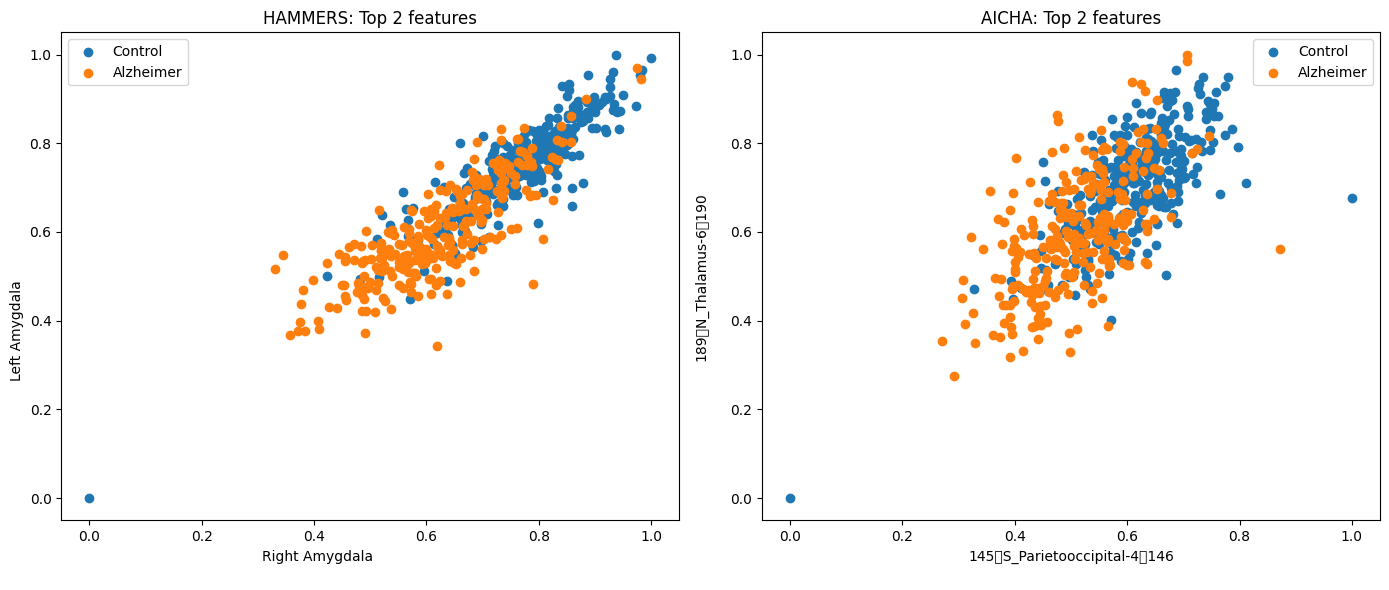

In [215]:
# Comparaison avec l'atlas HAMMERS
X_hammers = T1HAMMERS
labels_hammers = ROIlabelsHAMMERS
print(f'Dimensions des données HAMMERS: {X_hammers.shape}')

# split, normalisation et entrainement avec arbre
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hammers, y, test_size=0.2, random_state=10)
y_train_h = y_train_h.ravel()
y_test_h = y_test_h.ravel()
scaler_h = MinMaxScaler()
X_train_h = scaler_h.fit_transform(X_train_h)
X_test_h = scaler_h.transform(X_test_h)
Tree_h = DecisionTreeClassifier(random_state=0)
Tree_h.fit(X_train_h, y_train_h)
print('\n--- Arbre de décision simple (HAMMERS) ---')
print(f'Score train: {Tree_h.score(X_train_h, y_train_h):.3f}')
print(f'Score test: {Tree_h.score(X_test_h, y_test_h):.3f}')

# meilleurs hyperparamètres
print('\n--- Recherche de paramètres (GridSearchCV) ---')
Tree_grid_h = DecisionTreeClassifier(random_state=0)
p_grid_h = {
    'min_samples_split': [2, 5, 8, 11, 14],
    'min_samples_leaf': [1, 3, 5]
}
grid_h = GridSearchCV(Tree_grid_h, p_grid_h, cv=5, n_jobs=-1)
grid_h.fit(X_train_h, y_train_h)
print(f"Meilleurs paramètres: {grid_h.best_params_}")
print(f"Score avec meilleurs paramètres: {grid_h.score(X_test_h, y_test_h):.3f}")

# Random Forest
print('\n--- Random Forest (HAMMERS) ---')
RF_h = RandomForestClassifier(
    min_samples_leaf=grid_h.best_params_['min_samples_leaf'],
    min_samples_split=grid_h.best_params_['min_samples_split'],
    max_features='sqrt',
    n_estimators=100,
    random_state=0
)
RF_h.fit(X_train_h, y_train_h)
print(f'Score train: {RF_h.score(X_train_h, y_train_h):.3f}')
print(f'Score test: {RF_h.score(X_test_h, y_test_h):.3f}')

# Importance des features
importances_h = RF_h.feature_importances_
indices_h = np.argsort(importances_h)[::-1]

print("\n--- Features les plus importantes (HAMMERS) ---")
for f in range(10):
    print(f"{f+1}. {labels_hammers[indices_h[f]]} (importance: {importances_h[indices_h[f]]:.4f})")

# 6. Visualisation des importances
plt.figure(figsize=(12, 6))
plt.title("Importance des features (HAMMERS)")
plt.bar(range(10), importances_h[indices_h[:10]], color="r", align="center")
plt.xticks(range(10), [labels_hammers[i] for i in indices_h[:10]], rotation=90)
plt.tight_layout()
plt.show()

# Comparaison avec AICHA
print("\n--- Comparaison HAMMERS vs AICHA ---")
# Récupérer les résultats de RandomForest avec AICHA
RF_aicha = RandomForestClassifier(
    min_samples_leaf=best_params_RF["min_samples_leaf"],
    max_features=best_params_RF["max_features"],
    n_estimators=best_params_RF["n_estimators"], 
    random_state=0
)
RF_aicha.fit(X_train, y_train)

print(f"Score test HAMMERS: {RF_h.score(X_test_h, y_test_h):.3f}")
print(f"Score test AICHA: {RF_aicha.score(X_test, y_test):.3f}")

# Comparer les importances des features les plus importantes
importances_aicha = RF_aicha.feature_importances_
indices_aicha = np.argsort(importances_aicha)[::-1]

print("\nTop 5 features HAMMERS:")
for f in range(5):
    print(f"{f+1}. {labels_hammers[indices_h[f]]} (importance: {importances_h[indices_h[f]]:.4f})")

print("\nTop 5 features AICHA:")
for f in range(5):
    print(f"{f+1}. {labels[indices_aicha[f]]} (importance: {importances_aicha[indices_aicha[f]]:.4f})")

# Visualisation comparative des distributions des principales features
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for i, label in [(0, 'Control'), (1, 'Alzheimer')]:
    plt.scatter(X_train_h[y_train_h == i, indices_h[0]], 
                X_train_h[y_train_h == i, indices_h[1]], 
                label=label)
plt.xlabel(labels_hammers[indices_h[0]])
plt.ylabel(labels_hammers[indices_h[1]])
plt.title('HAMMERS: Top 2 features')
plt.legend()

plt.subplot(1, 2, 2)
for i, label in [(0, 'Control'), (1, 'Alzheimer')]:
    plt.scatter(X_train[y_train.ravel() == i, indices_aicha[0]], 
                X_train[y_train.ravel() == i, indices_aicha[1]], 
                label=label)
plt.xlabel(labels[indices_aicha[0]])
plt.ylabel(labels[indices_aicha[1]])
plt.title('AICHA: Top 2 features')
plt.legend()
plt.tight_layout()
plt.show()

### Conclusion sur les différences entre les atlas

L'Atlas Hammer donne des performances légèrement supérieures.

De plus, les régions d'intérêt identifiées comme les plus discriminantes sont différentes. 

Ces deux résultats suggèrent que l'approche d'atlas choisie peut influencer la performance de la détection des marqueurs de la maladie d'Alzheimer.